
# Costs and Barriers to Home Ownership along 
## the Mortgage Application Timeline

### _Alternate Chart Types to go with the Sankey flow charts in other notebook(s)_

##### Author: Kathryn Hurchla for Data Design Dimension (c) 2021
exploratory data analysis
for Design Labs: Industry Challenge,
MICA Data Analytics & Visualization
9/28/2021

## Key Questions

- Where do folks exit the home loan application process?
- How do loan costs look at that point?
- Which loans are closing and which are not?
- How prevalent are negatively amortizing loans?
- What is the volume of loans of modest prices for new construction, in relation to higher priced loans and other homes of modest loan prices?

### Having to Do with the False Claims Act (FCA)
- How prevalent are "credit overlays" in FHA loans?
- To what degree do FHA loans incur higher initial fees than non-FHA loans, as a lenders' step to avoid or curb losses from liabilities with the FCA?

### Primary Data Source

#### Housing Mortgage Disclosure Act (HMDA) Modified Loan Application Registrat (LAR), FFIEC
https://ffiec.cfpb.gov/data-publication/

## Prepare the data and analysis environment first

In [100]:
# Import the necessaries libraries
# # I will use matplotlib and seaborn for plots
# import matplotlib.pyplot as plt
# # from matplotlib.sankey import Sankey # limit this work to the Sankey notebook for this project
from matplotlib import rcParams
import matplotlib as mpl
import cufflinks as cf
import seaborn as sns
import chart_studio.plotly as py
# commented out because plotly express was taking too long to render plots with this dataset
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import pandas as pd
import numpy as np
import sys # to find version and check directories
from IPython.display import display_html # to change Pandas styling methods (use styler objects, i.e. side by side data tables)

In [73]:
# # for troubleshooting
# from plotly import exceptions

In [74]:
# # for troubleshooting check where the notebook is searching from
# import sys
# sys.path

In [75]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Prepare the plotting environment for consistent style

Set the plot palette and other style constants

In [243]:
# set a plotly palette
# # alternately assign specific colors from mood board in graphs directly
# set Seaborn palette
sns.set_style("whitegrid")
# set Seaborn palette
sns.set_palette("Set2_r") # for categorical, just reversed this showing less of the pink hue values
# # check the location of my matplotlib font cache file to see what the default fonts are
# mpl.get_cachedir()
# # check my Python version to know which cache file to look for
# print(sys.version)
from matplotlib.font_manager import findfont, FontProperties # unless the full matplotlib module is imported already, this part is needed
# # check the sans-serif font
# font = findfont(FontProperties(family=['sans-serif']))
# font

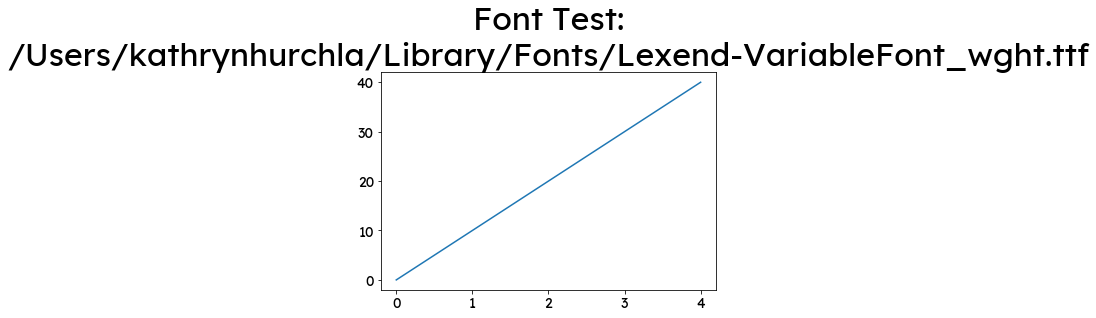

In [77]:
# set an overall font for plots
# for font troubleshooting, reference this super helpful stackoverflow at https://stackoverflow.com/questions/59391050/unable-to-use-custom-fonts-in-matplotlib
# after manually moving the font cache file from that location to my trash,
# rebuild the font cache, by running this and restarting the python kernel
# set the parameter for sans serif font
mpl.rcParams['font.family'] = 'sans-serif'
# for sans serif fonts, set a list of font family styles to try to find in this order
mpl.rcParams['font.sans-serif'] = ['Lexend', 'Roboto', 'Verdana', 'Tahoma', 'DejaVu Sans', 'Lucida Grande'] # note as of matplotlib 2.0 DejaVu Sans is default font
# assign default font size
mpl.rcParams['font.size']  = 14

# check the sans-serif font again
font = findfont(FontProperties(family=['sans-serif']))
# test that now instead of the previous font listed, now the new font shows
plt.plot(range(0,50,10))
plt.title('Font Test:\n' + str(font), size=32)
plt.show();

### Great, now I'm running my preferred Lexend font!

The matplotlib font cache file was rebuilt in my user directory, and the same default DejaVu Sans remain there, but now Lexend is listed there as an available font, and anytime I designate it using rcParams in the future it will be used.

### Load the Data

Initially, I loaded the full dataset on the most recent 2020 year available of HMDA LAR, and ultimately opted to use and load only two specific variables, Activity Year and Action Taken, then loaded and combined with the same information for the years 2018 and 2019 also managed by and available from the FFIEC Data Explorer and API.

In [ ]:
# Using %stored variables
# refresh all variables, aliased and directory history
%store -r

# view the number of rows and columns
# # separated by year dataframes
# df_2020_single_purch_terminal.shape
# df_2019_single_purch_terminal.shape
# df_2018_single_purch_terminal.shape

# single combined with year variable
df_181920_single_purch_terminal.shape


# this will include only the columns I need into year variables first, only primary residence loans, only single unit, only terminal loan records (origination were removed)
# note otherwise the original source of data would be, but
# additional processing has already been done on this variable in notebook: /notebooks/barriers-to-homeownership-viewed-through-HMDA-LAR.ipynb
##df_2020_single_purch_allvars = pd.read_csv("../data/hmda_ffiec_nationwide_2020_one-unit_home_purchase.csv", usecols=['activity_year','action_taken', 'occupancy_type'], low_memory=False)

### Review the data

In [79]:
# check the data types
df_181920_single_purch_terminal.dtypes
# view the head
df_181920_single_purch_terminal.head()

activity_year                   int64
action_taken                  float64
stage                          object
action_taken_mapped_labels     object
dtype: object

,activity_year,action_taken,stage,action_taken_mapped_labels
2,2018,3.0,Decision,Application denied
3,2018,2.0,Decision,Application approved but not accepted
11,2018,3.0,Decision,Application denied
26,2018,3.0,Decision,Application denied
27,2018,3.0,Decision,Application denied


#### Note action taken remains an integrer value

I can handle labelling in charts, or repeat the stets to assign dictionary definition/description values if that is more efficient.

## Quick plot to compare overall activity counts year over year

In [80]:
# quickref colors to align with flow chart sections for stages (?)

# some doc titles/elements: '#000080' (True Navy)
# chart titles: #353535' Urban charts dark
# accent/quotes/active hyperlinks: #4c2c92 (a deep purple hue)
# footnote/source text: '#989B98' a deemphasised gray

# Stages colored along a tonal spectrum range sequntial of Urban brand color (a medium blue hue)
# Preapproval: '#8ACAE8'
# Underwriting: '#5BB5DF' 
# Decision: '#2DA0D6'

# year colors (? test) 
# 2020: '#169682' Urban brand color (a medium blue hue) -- will this be too close to stage colors? Use purple?
# 2019: '#353535' Urban charts dark
# 2018: '#989B98' a biophiliac gray shade of #dadeda

# meaningful highlight, limited use
# '#fdbf11' Urban charts highlight (a rich gold hue)
# 'r' text ultra highlight for focal point callouts ('red') / show an error during plotting

In [81]:
# recreate to reorder and shorten the mapping dictionary to only terminal exits actions
dic_action_taken_terminalord = {8: 'Preapproval request approved but not accepted', 7: 'Preapproval request denied', 4: 'Application withdrawn by applicant', 5: 'File closed for incompleteness', 2: 'Application approved but not accepted', 6: 'Purchased loan', 3: 'Application denied'}

In [82]:
# make the tuple into a dataframe to resolve plotting error:
# ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
df_181920_single_purch_terminal = pd.DataFrame(df_181920_single_purch_terminal)
# now test if it is a tuple
print('Is it a tuple? ') 
isinstance(df_181920_single_purch_terminal, tuple)

Is it a tuple? 


False

In [83]:
print('Is it a dataframe now? ') 
isinstance(df_181920_single_purch_terminal, pd.DataFrame)

Is it a dataframe now? 


True

In [86]:
# use whole table of all years df_181920_single_purch

title = 'Slope chart test 2018-2020'

# map the actual descriptions of actions from stored data dictionary to label safely in place of key values in data 
df_181920_single_purch_terminal["action_taken_mapped_labels"] = df_181920_single_purch_terminal["action_taken"].map(dic_action_taken_terminalord)

labels = ['Preapproval request approved but not accepted', 'Preapproval request denied', 'Application withdrawn by applicant', 'File closed for incompleteness', 'Application approved but not accepted', 'Purchased loan', 'Application denied'] # df_181920_single_purch_terminal["action_taken_mapped_labels"]
# assign colors in order of dictionary: {8: '#8ACAE8', 7: '#8ACAE8', 4: '#5BB5DF', 5: '#5BB5DF', 2: '#2DA0D6', 6: '#2DA0D6', 3: '#2DA0D6'}]
colors = ['#8ACAE8', '#8ACAE8', '#5BB5DF', '#5BB5DF', '#2DA0D6', '#2DA0D6', '#2DA0D6']

mode_size = [8, 8, 8, 8, 8, 8, 8]
line_size = [2, 2, 2, 2, 2, 2, 2]

x_data = np.vstack((np.arange(df_181920_single_purch_terminal['activity_year'].any()),)*1)
# assign numpy array of actions taken in order of dictionary (same order as labels and colors which I can't yet get to map dynamically here)
# for ref: {8, 7, 4, 5, 2, 6, 3}
# for ref: {8: 'Preapproval request approved but not accepted', 7: 'Preapproval request denied', 4: 'Application withdrawn by applicant', 5: 'File closed for incompleteness', 2: 'Application approved but not accepted', 6: 'Purchased loan', 3: 'Application denied'}
y_data = np.array([
    [(df_181920_single_purch_terminal["action_taken_mapped_labels"] == 'Preapproval request approved but not accepted')],
    [(df_181920_single_purch_terminal["action_taken_mapped_labels"] == 'Preapproval request denied')],
    [(df_181920_single_purch_terminal["action_taken_mapped_labels"] == 'Application withdrawn by applicant')],
    [(df_181920_single_purch_terminal["action_taken_mapped_labels"] == 'File closed for incompleteness')], 
    [(df_181920_single_purch_terminal["action_taken_mapped_labels"] == 'Application approved but not accepted')], 
    [(df_181920_single_purch_terminal["action_taken_mapped_labels"] == 'Purchased loan')], 
    [(df_181920_single_purch_terminal["action_taken_mapped_labels"] == 'Application denied')],
#     [(df_181920_single_purch_terminal["action_taken"] == 8)],
#     [(df_181920_single_purch_terminal["action_taken"] == 7)],
#     [(df_181920_single_purch_terminal["action_taken"] == 4)],
#     [(df_181920_single_purch_terminal["action_taken"] == 5)], 
#     [(df_181920_single_purch_terminal["action_taken"] == 2)], 
#     [(df_181920_single_purch_terminal["action_taken"] == 6)], 
#     [(df_181920_single_purch_terminal["action_taken"] == 3)],
])#df_181920_single_purch_terminal["action_taken"])

fig = go.Figure()

for i in range(0, 6):
    fig.add_trace(go.Scatter(x=x_data[i], y=y_data[i], mode='lines',
        name=labels[i],
        line=dict(color=colors[i], width=line_size[i]),
        connectgaps=True,
    ))

    # endpoints
    fig.add_trace(go.Scatter(
        x=[x_data[i][0], x_data[i][-1]],
        y=[y_data[i][0], y_data[i][-1]],
        mode='markers',
        marker=dict(color=colors[i], size=mode_size[i])
    ))

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='#989B98',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Lexend',
            size=12,
            color='#353535',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=False,
    ),
    autosize=False,
    margin=dict(
        autoexpand=False,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=False,
    plot_bgcolor='white'
)

annotations = []

# Adding labels
for y_trace, label, color in zip(y_data, labels, colors):
    # labeling the left_side of the plot
    annotations.append(dict(xref='paper', x=0.05, y=y_trace[0],
                                  xanchor='right', yanchor='middle',
                                  text=label + ' {}%'.format(y_trace[0]),
                                  font=dict(family='Lexend',
                                            size=16),
                                  showarrow=False))
    # labeling the right_side of the plot
    annotations.append(dict(xref='paper', x=0.95, y=y_trace[11],
                                  xanchor='left', yanchor='middle',
                                  text='{}%'.format(y_trace[11]),
                                  font=dict(family='Lexend',
                                            size=16),
                                  showarrow=False))
# Title
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Main Source for News',
                              font=dict(family='Lexend',
                                        size=30,
                                        color='#353535'),
                              showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Source: FFIEC Housing Mortgage Disclosure Act Modified Loan Application Registrat, FFIEC',
                              font=dict(family='Lexend',
                                        size=12,
                                        color='#989B98'),
                              showarrow=False))

fig.update_layout(annotations=annotations)

fig.show();

KeyboardInterrupt: 

In [ ]:
y_data

In [90]:
# use whole table of all years df_181920_single_purch
# Using %stored variables
# refresh all variables, aliased and directory history
%store -r

title = 'Slope chart test 2018-2020'

labels = ['Preapproved but not accepted', 'Preapproval denied', 'Application withdrawn by applicant', 'File closed for incompleteness', 'Application approved but not accepted', 'Purchased loan', 'Application denied']
# assign colors in order of dictionary: {8: '#8ACAE8', 7: '#8ACAE8', 4: '#5BB5DF', 5: '#5BB5DF', 2: '#2DA0D6', 6: '#2DA0D6', 3: '#2DA0D6'}]
colors = ['#8ACAE8', '#8ACAE8', '#5BB5DF', '#5BB5DF', '#2DA0D6', '#2DA0D6', '#2DA0D6']

mode_size = [8, 8, 8, 8, 8, 8, 8]
line_size = [2, 2, 2, 2, 2, 2, 2]

x_data = np.array([2018, 2019, 2020])
y_data = np.array(['Preapproval request approved but not accepted', 'Preapproval request denied', 'Application withdrawn by applicant', 'File closed for incompleteness', 'Application approved but not accepted', 'Purchased loan', 'Application denied'])

fig = go.Figure()

for i in range(0, 6):
    fig.add_trace(go.Scatter(x=x_data[i], y=y_data[i], mode='lines',
        name=labels[i],
        line=dict(color=colors[i], width=line_size[i]),
        connectgaps=True,
    ))

    # endpoints
    fig.add_trace(go.Scatter(
        x=[x_data[i][0], x_data[i][-1]],
        y=[y_data[i][0], y_data[i][-1]],
        mode='markers',
        marker=dict(color=colors[i], size=mode_size[i])
    ))

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='#989B98',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Lexend',
            size=12,
            color='#353535',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=False,
    ),
    autosize=False,
    margin=dict(
        autoexpand=False,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=False,
    plot_bgcolor='white'
)

annotations = []

# Adding labels
for y_trace, label, color in zip(y_data, labels, colors):
    # labeling the left_side of the plot
    annotations.append(dict(xref='paper', x=0.05, y=y_trace[0],
                                  xanchor='right', yanchor='middle',
                                  text=label + ' {}%'.format(y_trace[0]),
                                  font=dict(family='Lexend',
                                            size=16),
                                  showarrow=False))
    # labeling the right_side of the plot
    annotations.append(dict(xref='paper', x=0.95, y=y_trace[11],
                                  xanchor='left', yanchor='middle',
                                  text='{}%'.format(y_trace[11]),
                                  font=dict(family='Lexend',
                                            size=16),
                                  showarrow=False))
# Title
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Main Source for News',
                              font=dict(family='Lexend',
                                        size=30,
                                        color='#353535'),
                              showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Source: FFIEC Housing Mortgage Disclosure Act Modified Loan Application Registrat, FFIEC',
                              font=dict(family='Lexend',
                                        size=12,
                                        color='#989B98'),
                              showarrow=False))

fig.update_layout(annotations=annotations)

fig.show();

ValueError: 
    Invalid value of type 'numpy.int64' received for the 'x' property of scatter
        Received value: 2018

    The 'x' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [142]:
# rename the columns that had spaces, and view the stored data table variable
# df_yoy.rename(columns={'Terminal action taken': 'action_taken', "Percent of completed applications (yr.)": "annual_percent_term_apps"})

# df_yoy.rename(index={'Terminal action taken': 'action_taken', 'Percent of completed applications (yr.)': 'percent'})
df_yoy

,Terminal action taken,Percent of completed applications (yr.),Year
0,Preapproved but not accepted,2.216321,2018
1,Preapproved but not accepted,2.165569,2019
2,Preapproved but not accepted,2.060772,2020
3,Preapproval denied,3.144855,2018
4,Preapproval denied,2.351292,2019
5,Preapproval denied,1.743239,2020
6,Application withdrawn by applicant,23.577277,2018
7,Application withdrawn by applicant,24.381556,2019
8,Application withdrawn by applicant,28.851476,2020
9,File closed for incompleteness,5.468343,2018


In [143]:
df_yoy = pd.DataFrame(df_yoy)

In [144]:
df_yoy.dtypes
df_yoy.columns.values[0]
df_yoy.columns.values[1]
df_yoy.columns.values[2]

Terminal action taken                       object
Percent of completed applications (yr.)    float64
Year                                         int64
dtype: object

'Terminal action taken'

'Percent of completed applications (yr.)'

'Year'

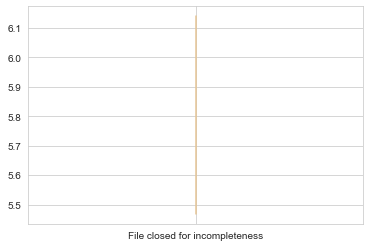

In [234]:
# first just test to plot one line value
# temp = df_yoy[df_yoy['action_taken'] == 'File closed for incompleteness']
# plt.plot(temp.Year, temp.percent)
temp = df_yoy[df_yoy['Terminal action taken'] == 'File closed for incompleteness']
plt.plot(temp['Terminal action taken'], temp['Percent of completed applications (yr.)'])
plt.show();

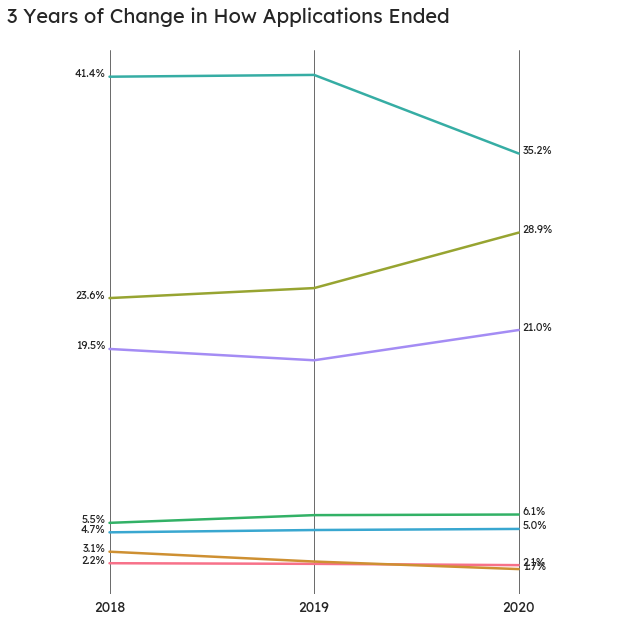

<Figure size 432x288 with 0 Axes>

In [338]:
# try slope chart with matplotlib

# adding a deeper palette for small lines and with minimal luminance fluctuation
sns.set_palette("husl", 8)

labels = ['Preapproved but not accepted', 
          'Preapproval denied', 
          'Application withdrawn by applicant', 
          'File closed for incompleteness', 
          'Application approved but not accepted', 
          'Purchased loan', 
          'Application denied'
         ]

# assign colors in order of dictionary: {8: '#8ACAE8', 7: '#8ACAE8', 4: '#5BB5DF', 5: '#5BB5DF', 2: '#2DA0D6', 6: '#2DA0D6', 3: '#2DA0D6'}]
colors = sns.husl_palette(8)
#colors = ['#8ACAE8', '#8ACAE8', '#5BB5DF', '#5BB5DF', '#2DA0D6', '#2DA0D6', '#2DA0D6']

# set the figure and axes
figyoy, ax = plt.subplots(1, figsize=(11,10))
# set background to transparent
figyoy.patch.set_facecolor('none')
figyoy.patch.set_alpha(0.0)

for i, v in enumerate(labels):
    # get a single action_taken from the list
    temp = df_yoy[df_yoy['Terminal action taken'] == v]
    # plot the lines with filled dot marks at the ends
    plt.plot(temp.Year, 
             temp['Percent of completed applications (yr.)'], 
             color=colors[i],
             lw=2.5)#,
#              marker='o', 
#              markersize=5)
    # start label the lines
    # with the percents for year mark
    plt.text(temp.Year.values[0]-0.02, 
             temp['Percent of completed applications (yr.)'].values[0], 
             '{:.1f}%'.format(temp['Percent of completed applications (yr.)'].values[0]), 
             ha='right', 
             font=dict(family='Lexend', size=11))
    # end label with the percents for year mark
    plt.text(temp.Year.values[2]+0.02, 
             temp['Percent of completed applications (yr.)'].values[2], 
             '{:.1f}%'.format(temp['Percent of completed applications (yr.)'].values[2]), 
             ha='left',
             font=dict(family='Lexend', size=11))

# NEEDS MORE WORK TO ALIGN CORRECT LOCATIONS MANUALLY    
# #     correction = 0
# #     if v == 'Application withdrawn by applicant': correction = 500
#     plt.text(2018.5, 
#              temp['Percent of completed applications (yr.)'].values[1],# + 1,# - correction, 
#              v, color=colors[i],
#              va='top', ha='center', fontsize=12)    

# set x limits, x ticks
# plt.xlim(2017.95,2020.05)
plt.xlim(2017.5, 2020.5)
plt.xticks([2018, 2019, 2020], font=dict(family='Lexend', size=14))

# get y ticks, format as percent, and draw the ticks
yticks = plt.yticks()[0]
# plt.yticks(yticks, ['{:.1f}%'.format(i) for i in yticks], font=dict(family='Lexend', size=12))    
# suppress y ticks
plt.yticks([])

# grid
ax.xaxis.grid(color='#353535', linestyle='solid', which='both', alpha=0.9)
# hide the y axis because the % values are labelled
# ax.yaxis.grid(color='#353535', linestyle='dashed', which='both', alpha=0.1)

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('3 Years of Change in How Applications Ended\n', loc='left', font=dict(family='Lexend', size=20))

# # go with a legend because there's little space for direct labelling in some of these
# plt.legend(labels, bbox_to_anchor=(1, 1), loc='upper left', frameon=False)

plt.show()
plt.savefig('../output/one_unit_home_mortgage_terminal_slope_yoy_transparent.png', dpi=100, edgecolor='none',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1);

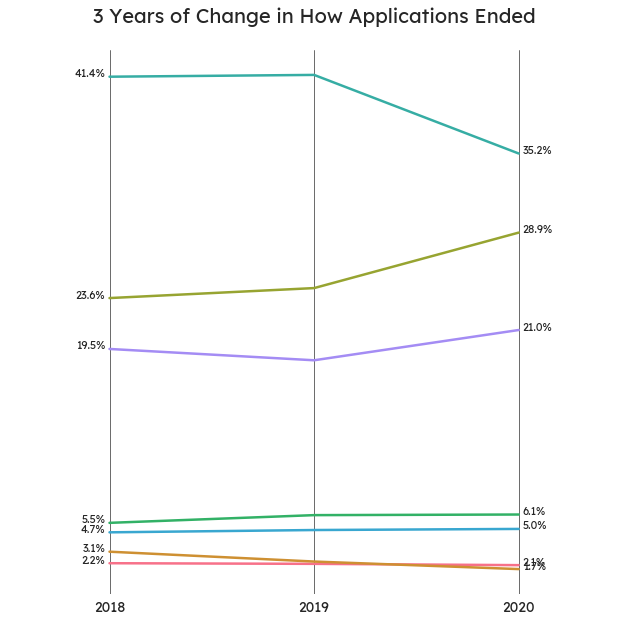

<Figure size 432x288 with 0 Axes>

In [359]:
# try slope chart with matplotlib

# adding a deeper palette for small lines and with minimal luminance fluctuation
sns.set_palette("husl", 8)

labels = ['Preapproved but not accepted', 
          'Preapproval denied', 
          'Application withdrawn by applicant', 
          'File closed for incompleteness', 
          'Application approved but not accepted', 
          'Purchased loan', 
          'Application denied'
         ]

# assign colors in order of dictionary: {8: '#8ACAE8', 7: '#8ACAE8', 4: '#5BB5DF', 5: '#5BB5DF', 2: '#2DA0D6', 6: '#2DA0D6', 3: '#2DA0D6'}]
colors = sns.husl_palette(8)
#colors = ['#8ACAE8', '#8ACAE8', '#5BB5DF', '#5BB5DF', '#2DA0D6', '#2DA0D6', '#2DA0D6']

# set the figure and axes
figyoy, ax = plt.subplots(1, figsize=(11,10))
# set background to transparent
figyoy.patch.set_facecolor('none')
figyoy.patch.set_alpha(0.0)

for i, v in enumerate(labels):
    # get a single action_taken from the list
    temp = df_yoy[df_yoy['Terminal action taken'] == v]
    # plot the lines with filled dot marks at the ends
    plt.plot(temp.Year, 
             temp['Percent of completed applications (yr.)'], 
             color=colors[i],
             lw=2.5)#,
#              marker='o', 
#              markersize=5)
    # start label the lines
    # with the percents for year mark
    plt.text(temp.Year.values[0]-0.02, 
             temp['Percent of completed applications (yr.)'].values[0], 
             '{:.1f}%'.format(temp['Percent of completed applications (yr.)'].values[0]), 
             ha='right', 
             font=dict(family='Lexend', size=11))
    # end label with the percents for year mark
    plt.text(temp.Year.values[2]+0.02, 
             temp['Percent of completed applications (yr.)'].values[2], 
             '{:.1f}%'.format(temp['Percent of completed applications (yr.)'].values[2]), 
             ha='left',
             font=dict(family='Lexend', size=11))

# NEEDS MORE WORK TO ALIGN CORRECT LOCATIONS MANUALLY    
# #     correction = 0
# #     if v == 'Application withdrawn by applicant': correction = 500
#     plt.text(2018.5, 
#              temp['Percent of completed applications (yr.)'].values[1],# + 1,# - correction, 
#              v, color=colors[i],
#              va='top', ha='center', fontsize=12)    

# set x limits, x ticks
# plt.xlim(2017.95,2020.05)
plt.xlim(2017.5, 2020.5)
plt.xticks([2018, 2019, 2020], font=dict(family='Lexend', size=14))

# get y ticks, format as percent, and draw the ticks
yticks = plt.yticks()[0]
# plt.yticks(yticks, ['{:.1f}%'.format(i) for i in yticks], font=dict(family='Lexend', size=12))    
# suppress y ticks
plt.yticks([])

# grid
ax.xaxis.grid(color='#353535', linestyle='solid', which='both', alpha=0.9)
# hide the y axis because the % values are labelled
# ax.yaxis.grid(color='#353535', linestyle='dashed', which='both', alpha=0.1)

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('3 Years of Change in How Applications Ended\n', loc='center', font=dict(family='Lexend', size=20))

# # go with a legend because there's little space for direct labelling in some of these
# plt.legend(labels, bbox_to_anchor=(.9, 1), loc='upper left', frameon=False)

plt.show()
plt.savefig('../output/one_unit_home_mortgage_terminal_slope_yoy_transparent.png', dpi=100, edgecolor='none',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1);

In [361]:
# with transparent background, to test an image behind in Illustrator
figyoy.savefig('../output/one_unit_home_mortgage_terminal_slope_yoy_transparent.png', dpi=100, edgecolor='none',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1)

In [104]:
# check the temp result is empty
temp.shape 
temp

(0, 3)

,Terminal action taken,Percent of completed applications (yr.),Year


### Focus the data on the question of where folks exit the process

Remove applications that did not reach a terminal point, i.e remove those in origination stage, and keep only rows in Preapproval, Underwriting, Decision.

These should already be done in the stored variable...

In [85]:
# these should already be done in the stored variable...
# first for the separate 2020 table, assign a variable to just rows where stage is not origination 
df2020_not_origination =  df_2020_single_purch['stage']!='Origination'
# view the top seven to confirm versus values printed earlier in notebook
print(df2020_not_origination.head(7))

NameError: name 'df_2020_single_purch' is not defined

In [ ]:
# update the 2020 dataframe on only applications isolated as not in origination above 
# by calling that variable as a subset of the dataframe
df_2020_single_purch_terminal = df_2020_single_purch[df2020_not_origination]
# view the top rows to confirm the origination have been removed
# first before origination is removed
df_2020_single_purch.head()
# then after which should no longer show origination rows
df_2020_single_purch_terminal.head()

In [ ]:
# for 2019 now, do the same; assign a variable to just rows where stage is not origination 
df2019_not_origination =  df_2019_single_purch['stage']!='Origination'
# view the top seven to confirm versus values printed earlier in notebook
print(df2019_not_origination.head(7))

In [ ]:
# update the 2019 dataframe on only applications isolated as not in origination above 
# by calling that variable as a subset of the dataframe
df_2019_single_purch_terminal = df_2019_single_purch[df2019_not_origination]
# view the top rows to confirm the origination have been removed
# first before origination is removed
df_2019_single_purch.head()
# then after which should no longer show origination rows
df_2019_single_purch_terminal.head()
# since these are all the same, check the number of rows has gone down
df_2019_single_purch_terminal.shape
# check total number of rows again
df_2019_single_purch.shape
# repeat the same but reverse process to find rows equal to origination
df2019_origination =  df_2019_single_purch['stage']=='Origination'
df_2019_single_purch_origination = df_2019_single_purch[df2019_origination]
# check how many rows i.e. applications were in origination
df_2019_single_purch_origination.shape

In [ ]:
# for 2018 now, do the same; assign a variable to just rows where stage is not origination 
df2018_not_origination =  df_2018_single_purch['stage']!='Origination'
# view the top seven to confirm versus values printed earlier in notebook
print(df2018_not_origination.head(7))

In [ ]:
# update the 2018 dataframe on only applications isolated as not in origination above 
# by calling that variable as a subset of the dataframe
df_2018_single_purch_terminal = df_2018_single_purch[df2018_not_origination]
# view the top rows to confirm the origination have been removed
# first before origination is removed
df_2018_single_purch.head()
# then after which should no longer show origination rows
df_2018_single_purch_terminal.head()

In [ ]:
# for the combined 2018-2020 dataframe now, do the same; assign a variable to just rows where stage is not origination 
df181920_not_origination =  df_181920_single_purch['stage']!='Origination'
# view the top seven to confirm versus values printed earlier in notebook
print(df181920_not_origination.head(7))

In [ ]:
# update the 2018-2020 dataframe on only applications isolated as not in origination above 
# by calling that variable as a subset of the dataframe
df_181920_single_purch_terminal = df_181920_single_purch[df181920_not_origination]
# view the top rows to confirm the origination have been removed
# first before origination is removed
df_181920_single_purch.head()
# then after which should no longer show origination rows
df_181920_single_purch_terminal.head()

## Now let's plot some data!

### Where do folks exit the home loan application process?


In [ ]:
# find total length of dataframe i.e. number of rows; this should match our result in shape function above
# for all years combined
index_181920_terminal = df_181920_single_purch_terminal.index
number_of_rows_181920_terminal = len(index_181920_terminal)
number_of_rows_181920_terminal
# for 2020 all applications/rows (for early process reference)
index_2020 = df_2020_single_purch.index
number_of_rows_2020 = len(index_2020)
number_of_rows_2020
# for 2020 terminal applications only
index_2020_terminal = df_2020_single_purch_terminal.index
number_of_rows_2020_terminal = len(index_2020_terminal)
number_of_rows_2020_terminal
# for 2019
index_2019 = df_2019_single_purch.index
number_of_rows_2019 = len(index_2019)
number_of_rows_2019
# for 2019 terminal applications only
index_2019_terminal = df_2019_single_purch_terminal.index
number_of_rows_2019_terminal = len(index_2019_terminal)
number_of_rows_2019_terminal
# for 2018
index_2018 = df_2018_single_purch.index
number_of_rows_2018 = len(index_2018)
number_of_rows_2018
# for 2018 terminal applications only
index_2018_terminal = df_2018_single_purch_terminal.index
number_of_rows_2018_terminal = len(index_2018_terminal)
number_of_rows_2018_terminal

## Plot years by Percent within each year

Plot each year separately first, starting with 2020

### 2020

In [ ]:
# make a matrix of just the variables for a sankey diagram with action_taken

# assign the select columns as percent
# no longer need col0 because origination are gone (commented out to leave for reference)
# col0 = (len(df_2020_single_purch_terminal[df_2020_single_purch_terminal['action_taken'] == 1])/number_of_rows_2020_terminal)*100
col1_2020 = (len(df_2020_single_purch_terminal[df_2020_single_purch_terminal['action_taken'] == 8])/number_of_rows_2020_terminal)*100
col2_2020 = (len(df_2020_single_purch_terminal[df_2020_single_purch_terminal['action_taken'] == 7])/number_of_rows_2020_terminal)*100
col3_2020 = (len(df_2020_single_purch_terminal[df_2020_single_purch_terminal['action_taken'] == 4])/number_of_rows_2020_terminal)*100
col4_2020 = (len(df_2020_single_purch_terminal[df_2020_single_purch_terminal['action_taken'] == 5])/number_of_rows_2020_terminal)*100
col5_2020 = (len(df_2020_single_purch_terminal[df_2020_single_purch_terminal['action_taken'] == 6])/number_of_rows_2020_terminal)*100
col6_2020 = (len(df_2020_single_purch_terminal[df_2020_single_purch_terminal['action_taken'] == 2])/number_of_rows_2020_terminal)*100
col7_2020 = (len(df_2020_single_purch_terminal[df_2020_single_purch_terminal['action_taken'] == 3])/number_of_rows_2020_terminal)*100

In [ ]:
# test that it adds up to 100%
test_2020 = col1_2020 + col2_2020 + col3_2020 + col4_2020 + col5_2020 + col6_2020 + col7_2020
test_2020

In [ ]:
# assign stage groups of flow nodes
# no longer need col0 because origination are gone (commented out to leave for reference)
# cols0_7 = (col0 + col1 + col2 + col3 + col4 + col5 + col6 + col7) # Origination start
cols1_7_2020 = (col1_2020 + col2_2020 + col3_2020 + col4_2020 + col5_2020 + col6_2020 + col7_2020) # Preapproval
cols3_7_2020 = (col3_2020 + col4_2020 + col5_2020 + col6_2020 + col7_2020) # Underwriting 
cols5_7_2020 = (col5_2020 + col6_2020 + col7_2020) # Underwriting 

In [ ]:
# test that the inputs and outputs equal tht number of rows
test_2020 = cols1_7_2020 - col1_2020 - col2_2020 - col3_2020 - col4_2020 - col5_2020 - col6_2020 - col7_2020
test_2020 == number_of_rows_2020_terminal
number_of_rows_2020_terminal - test_2020


### 2019

In [ ]:
# for 2019 only now, make a matrix of just the variables for a sankey diagram with action_taken

# assign the select columns as percent
# no longer need col0 because origination are gone (commented out to leave for reference)
# col0 = (len(df_2020_single_purch_terminal[df_2020_single_purch_terminal['action_taken'] == 1])/number_of_rows_2020_terminal)*100
col1_2019 = (len(df_2019_single_purch_terminal[df_2019_single_purch_terminal['action_taken'] == 8])/number_of_rows_2019_terminal)*100
col2_2019 = (len(df_2019_single_purch_terminal[df_2019_single_purch_terminal['action_taken'] == 7])/number_of_rows_2019_terminal)*100
col3_2019 = (len(df_2019_single_purch_terminal[df_2019_single_purch_terminal['action_taken'] == 4])/number_of_rows_2019_terminal)*100
col4_2019 = (len(df_2019_single_purch_terminal[df_2019_single_purch_terminal['action_taken'] == 5])/number_of_rows_2019_terminal)*100
col5_2019 = (len(df_2019_single_purch_terminal[df_2019_single_purch_terminal['action_taken'] == 6])/number_of_rows_2019_terminal)*100
col6_2019 = (len(df_2019_single_purch_terminal[df_2019_single_purch_terminal['action_taken'] == 2])/number_of_rows_2019_terminal)*100
col7_2019 = (len(df_2019_single_purch_terminal[df_2019_single_purch_terminal['action_taken'] == 3])/number_of_rows_2019_terminal)*100

In [ ]:
# test that it adds up to 100%
test_2019 = col1_2019 + col2_2019 + col3_2019 + col4_2019 + col5_2019 + col6_2019 + col7_2019
test_2019

In [ ]:
# assign stage groups of flow nodes
# no longer need col0 because origination are gone (commented out to leave for reference)
# cols0_7 = (col0 + col1 + col2 + col3 + col4 + col5 + col6 + col7) # Origination start
cols1_7_2019 = (col1_2019 + col2_2019 + col3_2019 + col4_2019 + col5_2019 + col6_2019 + col7_2019) # Preapproval
cols3_7_2019 = (col3_2019 + col4_2019 + col5_2019 + col6_2019 + col7_2019) # Underwriting 
cols5_7_2019 = (col5_2019 + col6_2019 + col7_2019) # Underwriting 

In [ ]:
# test that the inputs and outputs equal the number of rows
test_2019 = cols1_7_2019 - col1_2019 - col2_2019 - col3_2019 - col4_2019 - col5_2019 - col6_2019 - col7_2019
test_2019 == number_of_rows_2019_terminal
number_of_rows_2019_terminal - test_2019

### 2018

In [ ]:
# for 2018 only now, make a matrix of just the variables for a sankey diagram with action_taken

# assign the select columns as percent
# no longer need col0 because origination are gone (commented out to leave for reference)
# col0 = (len(df_2020_single_purch_terminal[df_2020_single_purch_terminal['action_taken'] == 1])/number_of_rows_2020_terminal)*100
col1_2018 = (len(df_2018_single_purch_terminal[df_2018_single_purch_terminal['action_taken'] == 8])/number_of_rows_2018_terminal)*100
col2_2018 = (len(df_2018_single_purch_terminal[df_2018_single_purch_terminal['action_taken'] == 7])/number_of_rows_2018_terminal)*100
col3_2018 = (len(df_2018_single_purch_terminal[df_2018_single_purch_terminal['action_taken'] == 4])/number_of_rows_2018_terminal)*100
col4_2018 = (len(df_2018_single_purch_terminal[df_2018_single_purch_terminal['action_taken'] == 5])/number_of_rows_2018_terminal)*100
col5_2018 = (len(df_2018_single_purch_terminal[df_2018_single_purch_terminal['action_taken'] == 6])/number_of_rows_2018_terminal)*100
col6_2018 = (len(df_2018_single_purch_terminal[df_2018_single_purch_terminal['action_taken'] == 2])/number_of_rows_2018_terminal)*100
col7_2018 = (len(df_2018_single_purch_terminal[df_2018_single_purch_terminal['action_taken'] == 3])/number_of_rows_2018_terminal)*100

In [ ]:
# assign stage groups of flow nodes
# no longer need col0 because origination are gone (commented out to leave for reference)
# cols0_7 = (col0 + col1 + col2 + col3 + col4 + col5 + col6 + col7) # Origination start
cols1_7_2018 = (col1_2018 + col2_2018 + col3_2018 + col4_2018 + col5_2018 + col6_2018 + col7_2018) # Preapproval
cols3_7_2018 = (col3_2018 + col4_2018 + col5_2018 + col6_2018 + col7_2018) # Underwriting 
cols5_7_2018 = (col5_2018 + col6_2018 + col7_2018) # Underwriting 

In [ ]:
# test that the inputs and outputs equal tht number of rows
test_2018 = cols1_7_2018 - col1_2018 - col2_2018 - col3_2018 - col4_2018 - col5_2018 - col6_2018 - col7_2018
test_2018 == number_of_rows_2018_terminal
number_of_rows_2018_terminal - test_2018

In [ ]:
# test that it adds up to 100%
test_2018 = col1_2018 + col2_2018 + col3_2018 + col4_2018 + col5_2018 + col6_2018 + col7_2018
test_2018

### Focus in on the change year over year for Application withdrawn and File closed for completeness

#### Some image/size/style logistics (a parking lot)

In [ ]:
# # decrease the default font size for longer plot
# # assign default font size
# plt.rcParams['font.size']  = 12

In [ ]:
# # check the figure image stats
# print('Figure dpi: ', fig2020_all_stages.get_dpi())

# # Find the Figure size in inches
# print('\nFigure size (width, height):', fig2020_all_stages.get_size_inches())

# # Get the Figure width and height (inches)
# print('\nFigure width:', fig2020_all_stages.get_figwidth())
# print('Figure height:', fig2020_all_stages.get_figheight())

# # Get the Figure width and height (pixels)
# print('\nFigure pixel width:', fig2020_all_stages.get_figwidth() * fig2020_all_stages.get_dpi())
# print('Figure pixel height:', fig2020_all_stages.get_figheight() * fig2020_all_stages.get_dpi())

In [ ]:
# # with transparent background, to test an image behind in Illustrator
# fig2020.savefig('../output/one_unit_home_mortgage_activity_flow_2020_transparent_1.png', dpi=100, edgecolor='none',
#         orientation='landscape', format='png',
#         transparent=True, bbox_inches=None, pad_inches=0.1)

In [ ]:
# # save the figure as an image file
# # with its white background
# fig2020.savefig('../output/one_unit_home_mortgage_activity_flow_2020_horizonal_origination.png, dpi=100, facecolor='white', 
#         orientation='landscape', format='png',
#         transparent=False, bbox_inches=None, pad_inches=0.1)

# # with transparent background, to test an image behind in Illustrator
# fig2020.savefig('../output/one_unit_home_mortgage_activity_flow_2020_transparent_horizonal_origination.png', dpi=100, 
#         orientation='landscape', format='png',
#         transparent=True, bbox_inches=None, pad_inches=0.1)

### How do loan costs look at that point (upon exiting the loan application process)?

### Which loans are closing and which are not?

### What is the volume of loans of modest prices for new construction...?
_inspired by the Brookings topic number 2, Housing Supply, from its published Four Key Issues that Will Determine the Future of the Housing Market section_
_Brookings Institute Lessons from the financial crisis [1]_

#### ...in relation to higher priced loans?

#### ...in relation to other homes of modest loan prices?

### False Claims Act impact on FHA lending

_inspired by the Brookings topic number 3, False Claims Act, from its published Four Key Issues that Will Determine the Future of the Housing Market section_

"In the FHA context, lenders are required to make certifications when they submit loans to FHA for insurance. These include statements that the loan complies with the FHA eligibility standards, which are quite extensive and leave little room for even clerical mistakes.  The FCA does not require an intent to defraud, so these errors generate potential liability, even when they have little or no impact on the safety of the loan.  And that potential liability is huge....

Lenders have paid billions of dollars to settle these claims brought by the Justice Department.  As a result, lenders have taken several steps to avoid this liability.  Some major lenders have exited FHA lending entirely.  Many have added “credit overlays”- not making loans to lower credit score families, even though the loans are sound loans because they still have a higher risk of default and FCA liability only comes when a loan defaults.  Others have added additional fees to the loans to try to offset the cost of this liability."

_Brookings Institute Lessons from the financial crisis [1]_

1. What major lenders (by size or # of loans) are not doing FHA loans?
    - Note showing whether they previously did FHA loans prior to housing crisis would require pre-2018 data.
2. How often are FHA loans declined due to low credit score?
    - By top 10 individual lending institutions in # of loans fitting this question
3. How do total fees compare for FHA loans to non-FHA loans?
    - Is there a pattern in fees by particular lending institutions fitting this question?

### Federal Support for Housing Finance and GSE loans

_inspired by the Brookings topic number 4, Housing Secondary Market Finance, from its published Four Key Issues that Will Determine the Future of the Housing Market section_

The Government-Sponsored Enterprises, namely Federal National Mortgage Association (Fannie Mae) and Federal Home Mortgage Corporation (Freddie Mac), back the most common loans, called GSE loans [2, 3]. During the housing crisis of 2007 and 2008, housing prices plummeted and more loans became delinquent or went into default when the borrowers were unable to pay. These GSEs lost billions of dollars, having a tremendous impact on markets, and were later fined millions of dollars for improper accounting and misstatements and problems in control and governance. [3] 

To state it more simply, Fannie Mae and Freddie Mac had become so large by 2008, that the eventual outcome was that the Federal Housing Finance Administration (FHFA) placed both into conservatorships, where they
remain, unexpectedly, more than two decade later today in 2021, though what what many expect to be a gradual exit process began this year under the Biden Administration with its seeds planted by the Trump Administration. [1, 3, 4] 

1. Do GSE loans serve the broad group of qualified families who seek to become homeowners, , and not just serve the wealthiest and most profitable borrowers? [1]
    - How level is the pricing of the guarantee fees the GSE's charge, or total fees in absense of that variable?
2. Are GSE's fulfilling their explicitly duty to serve underserved markets? [1]
    - Can this be determined by census tracts or areas, and/or by race or ethnicity?

#### Quote to consider: growth of Latino families and the importance of affordable housing

"A healthy housing market, especially in the upcoming years, requires that this strong focus on affordable housing continues.  ... Looking forward, the housing market is increasingly comprised of more families without as much intergenerational wealth. Households of color – especially Latino families – account for the largest growth in households today, making it increasingly important that they are served."

_Brookings Institute Lessons from the financial crisis [1]_

#### Quote to consider: noteworthy drill down story of ethical lenders

"Disparate impact analysis encourages creative approaches that both increase effectiveness and inclusiveness.  This process and the value of disparate impact analysis was recently pointed out, and endorsed by, the largest personal loan company in the country, Lending Club, in its responses to requests for input by the CFPB.[28]  Taking care to reach rapidly-growing markets of borrowers of color when structuring business practices is good business.  And it is a false choice that inclusiveness is incompatible with growth and efficiency."

_Brookings Institute Lessons from the financial crisis [1]_

## Cited & Referenced

[]